In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
import numpy.linalg
from tqdm.auto import tqdm
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
from networkx.algorithms import community
import itertools
from sklearn.metrics import rand_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [2]:
#df = pd.DataFrame(arff.loadarff("../data/artificial/2d-10c.arff")[0]).sample(frac=1).reset_index(drop=True)
df = pd.DataFrame(arff.loadarff("../data/artificial/3-spiral.arff")[0])
#df = pd.DataFrame(arff.loadarff("../data/artificial/dense-disk-5000.arff")[0]).sample(frac=1).reset_index(drop=True)
#df = pd.DataFrame(arff.loadarff("../data/artificial/cluto-t4-8k.arff")[0]).sample(frac=1).reset_index(drop=True)
#df = pd.DataFrame(arff.loadarff("2sp2glob.arff")[0])
#df = pd.DataFrame(arff.loadarff("diamond9.arff")[0])
#df = pd.DataFrame(arff.loadarff("../data/artificial/2d-3c-no123.arff")[0]).sample(frac=1).reset_index(drop=True)
#df = pd.DataFrame(arff.loadarff("../data/artificial/donut2.arff")[0]).sample(frac=1).reset_index(drop=True)
df["CLASS"] = df["class"]
df["CLASS"] = df["CLASS"].map({x: i for i, x in enumerate(df["CLASS"].unique())})
df

,x,y,class,CLASS
0,31.95,7.95,b'3',0
1,31.15,7.30,b'3',0
2,30.45,6.65,b'3',0
3,29.70,6.00,b'3',0
4,28.90,5.55,b'3',0
...,...,...,...,...
307,15.75,13.85,b'2',2
308,15.65,14.05,b'2',2
309,15.65,14.25,b'2',2
310,15.65,14.50,b'2',2


In [3]:
X = df[["x", "y"]].to_numpy()

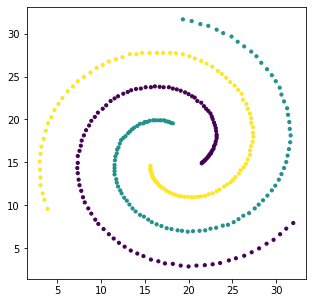

In [4]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=df["CLASS"], s=[10])

In [5]:
k = 10
#min_size = int(0.05 * len(X))

In [6]:
distance_matrix = euclidean_distances(X, X)

In [7]:
def build_k_nearest_neighbor_graph(X, k, d):
    graph = nx.Graph()

    for i in X:
        graph.add_node(i)

    for a in X:
        for b in np.argsort(distance_matrix[a])[1:k + 1]:
            graph.add_edge(a, b, weight=d[a][b], similarity=1/d[a][b])

    return graph

In [8]:
knng_original = build_k_nearest_neighbor_graph(set(range(len(X))), k, distance_matrix)

In [9]:
"""
def partition():
    knng = knng_original.copy()

    queue = [knng_original.copy()]

    while len(queue) > 0 and queue[0].number_of_nodes() > min_size:
        c = queue.pop(0)
        a, b = community.kernighan_lin_bisection(c, max_iter=100, weight="similarity", seed=42)
        queue.append(c.subgraph(a).copy())
        queue.append(c.subgraph(b).copy())

    knng = nx.Graph()

    for x in queue:
        knng = nx.compose(knng, x)

    plt.figure(figsize=(5, 5))
    nx.draw(knng, pos=X, node_size=1, node_color="black")
    plt.show()

    clusters = np.zeros(len(X), dtype=np.uint64)
    for i, x in enumerate(nx.connected_components(knng)):
        clusters[list(x)] = i

    return clusters"""

'\ndef partition():\n    knng = knng_original.copy()\n\n    queue = [knng_original.copy()]\n\n    while len(queue) > 0 and queue[0].number_of_nodes() > min_size:\n        c = queue.pop(0)\n        a, b = community.kernighan_lin_bisection(c, max_iter=100, weight="similarity", seed=42)\n        queue.append(c.subgraph(a).copy())\n        queue.append(c.subgraph(b).copy())\n\n    knng = nx.Graph()\n\n    for x in queue:\n        knng = nx.compose(knng, x)\n\n    plt.figure(figsize=(5, 5))\n    nx.draw(knng, pos=X, node_size=1, node_color="black")\n    plt.show()\n\n    clusters = np.zeros(len(X), dtype=np.uint64)\n    for i, x in enumerate(nx.connected_components(knng)):\n        clusters[list(x)] = i\n\n    return clusters'

In [10]:
def partition():
    clusters = np.zeros(len(X), dtype=np.uint64)
    cluster_idx = 1

    curr = set(range(len(X)))
    blacklist = set()

    knng = knng_original.copy()

    while len(knng.nodes()) > 0:
        knng_copy = knng.copy()

        plt.figure(figsize=(5, 5))
        nx.draw(knng, pos=X, node_size=1, node_color="black")
        plt.show()

        N_remove = len(knng.edges()) // 2
        i = 0
        for a, b, w in sorted(knng.edges(data=True), key=lambda x: x[2].get("weight", 1), reverse=True):
            if i >= N_remove:
                break

            if knng.has_edge(a, b):
                if knng.degree(a) > 1:
                    knng.remove_edge(a, b)
                    i += 1

            if knng.has_edge(b, a):
                if knng.degree(b) > 1:
                    knng.remove_edge(b, a)
                    i += 1

        subgraphs = sorted(list(nx.connected_components(knng)), key=lambda t: len(t), reverse=True)

        if len(subgraphs) > 0:
            subgraph_vertices = subgraphs[0]

            knng_copy.remove_nodes_from(subgraph_vertices)

            clusters[list(subgraph_vertices)] = cluster_idx

        cluster_idx += 1
        knng = knng_copy

    return clusters

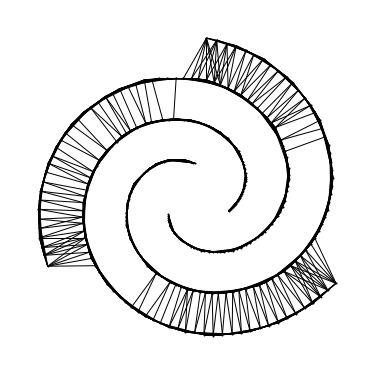

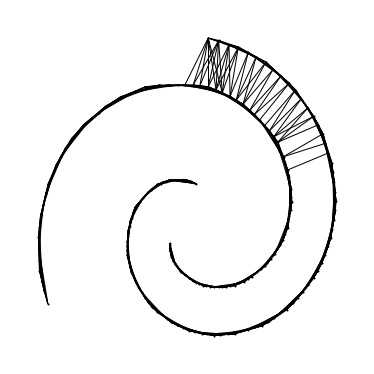

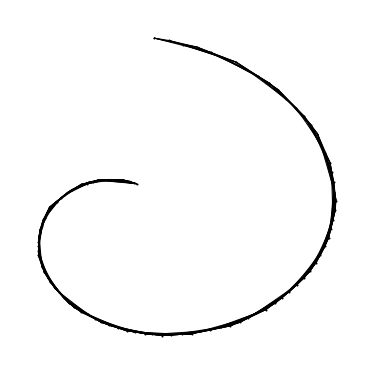

Wall time: 203 ms


In [11]:
%%time
clusters = partition()

In [12]:
%%time
knng = knng_original.copy()
cache = {}
cluster_history = [clusters.copy()]


def absolute_metrics(i, j):
    if (i, j) in cache:
        return cache[(i, j)]

    if (j, i) in cache:
        return cache[(j, i)]

    nodes_i = np.where(clusters == i)[0].tolist()
    nodes_j = np.where(clusters == j)[0].tolist()

    edges_i = knng.subgraph(nodes_i).copy().edges(data=True)
    edges_j = knng.subgraph(nodes_j).copy().edges(data=True)

    cluster = knng.subgraph(nodes_i + nodes_j).copy()
    cluster.remove_edges_from(edges_i)
    cluster.remove_edges_from(edges_j)

    if cluster.number_of_nodes() <= 0 or cluster.number_of_edges() <= 0:
        EC = 0
        SEC = 0
    else:
        EC = cluster.size(weight="similarity")
        SEC = cluster.size(weight="similarity") / cluster.number_of_edges()

    result = (EC, SEC)

    cache[(i, j)] = result

    return result


def internal_metrics(i):
    if i in cache:
        return cache[i]

    nodes = np.where(clusters == i)[0].tolist()

    cluster = knng.subgraph(nodes).copy()

    if cluster.number_of_nodes() <= 0 or cluster.number_of_edges() <= 0:
        result = (0, 0, 0)
    else:
        Ci = cluster.size(weight="similarity")

        a, b = community.kernighan_lin_bisection(cluster, max_iter=20, weight="similarity", seed=42)

        edges_a = cluster.subgraph(a).copy().edges(data=True)
        edges_b = cluster.subgraph(b).copy().edges(data=True)

        cluster.remove_edges_from(edges_a)
        cluster.remove_edges_from(edges_b)

        if cluster.number_of_nodes() <= 0 or cluster.number_of_edges() <= 0:
            ECci = 0
            SECci = 0
        else:
            ECci = cluster.size(weight="similarity")
            SECci = cluster.size(weight="similarity") / cluster.number_of_edges()

        result = (ECci, SECci, Ci)

    cache[i] = result

    return result


def merge_score(i, j):
    EC, SEC = absolute_metrics(i, j)
    ECci, SECci, Ci = internal_metrics(i)
    ECcj, SECcj, Cj = internal_metrics(j)

    ri = 2 * EC / (ECci + ECcj + 1e-6)
    rc = SEC / ((Ci / (Ci + Cj + 1e-6) * SECci) + (Cj / (Ci + Cj + 1e-6) * SECcj) + 1e-6)

    return ri, rc


def delete_cache(i, j):
    for x in np.unique(clusters):
        if (i, x) in cache:
            del cache[(i, x)]

        if (x, i) in cache:
            del cache[(x, i)]

        if (j, x) in cache:
            del cache[(j, x)]

        if (x, j) in cache:
            del cache[(x, j)]

    if i in cache:
        del cache[i]

    if j in cache:
        del cache[j]


while True:
    merged = False
    metrics = []

    for i, j in tqdm(list(itertools.combinations(np.unique(clusters), 2))):
        ri, rc = merge_score(i, j)
        metrics.append((i, j, ri, rc, ri * rc**2))

    metrics.sort(key=lambda x: x[4], reverse=True)

    for i, j, ri, rc, ri_rc in metrics:
        if ri_rc > 0.5:
            print(i, j, ri, rc, ri_rc)
            clusters[np.where(clusters == j)] = i
            merged = True
            delete_cache(i, j)
            break

    if merged:
        cluster_history.append(clusters.copy())
    else:
        break

  0%|          | 0/3 [00:00<?, ?it/s]

Wall time: 114 ms


In [13]:
def simplify_clusters(c):
    new_c = np.zeros_like(c)
    for i, x in enumerate(np.unique(c)):
        new_c[np.where(c == x)] = i
    return new_c

#clusters = simplify_clusters(clusters)

In [14]:
rand_score(df["CLASS"].to_numpy(), clusters), adjusted_rand_score(df["CLASS"].to_numpy(), clusters)

(1.0, 1.0)

In [15]:
kmeans_clusters = KMeans(n_clusters=df["CLASS"].nunique(), random_state=42).fit_predict(X)

In [16]:
rand_score(df["CLASS"].to_numpy(), kmeans_clusters), adjusted_rand_score(df["CLASS"].to_numpy(), kmeans_clusters)

(0.5540028031989447, -0.0060252369726964605)

In [17]:
dbscan_clusters = DBSCAN(eps=2, n_jobs=-1).fit_predict(X)

In [18]:
rand_score(df["CLASS"].to_numpy(), dbscan_clusters), adjusted_rand_score(df["CLASS"].to_numpy(), dbscan_clusters)

(0.9979388243053838, 0.9953410098732736)

3


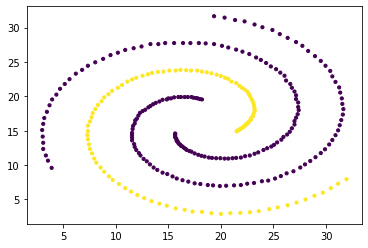

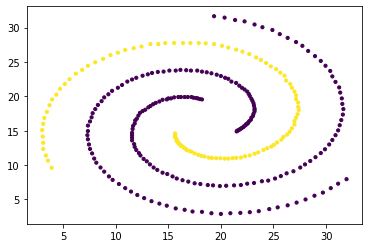

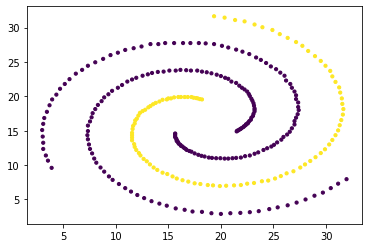

In [19]:
idx = -1
print(len(np.unique(cluster_history[idx])))
for i in np.unique(cluster_history[idx]):
    plt.scatter(X[:, 0], X[:, 1], c=(cluster_history[idx] == i), s=10)
    plt.show()

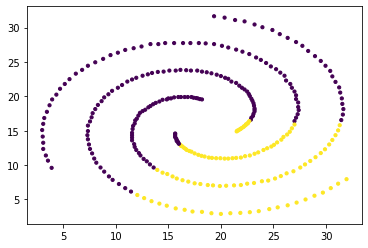

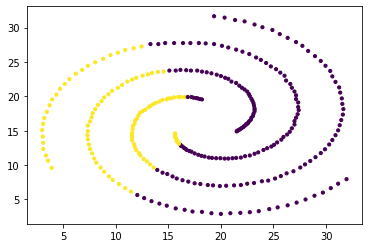

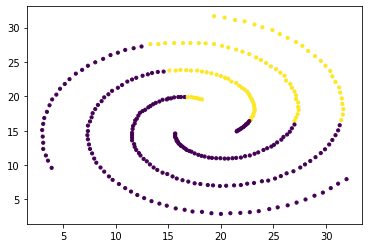

In [20]:
for i in np.unique(kmeans_clusters):
    plt.scatter(X[:, 0], X[:, 1], c=(kmeans_clusters == i), s=10)
    plt.show()

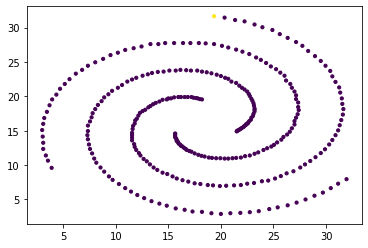

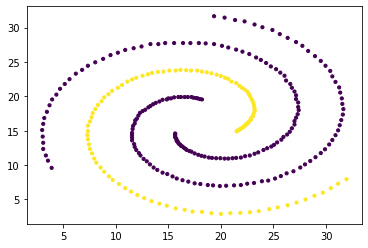

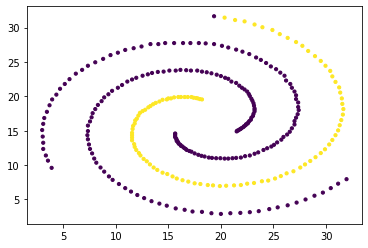

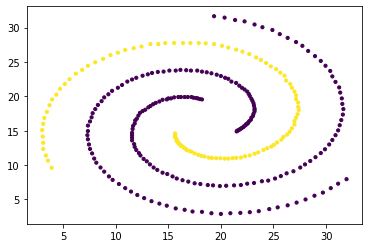

In [21]:
for i in np.unique(dbscan_clusters):
    plt.scatter(X[:, 0], X[:, 1], c=(dbscan_clusters == i), s=10)
    plt.show()